## TLDR;

- Linear regression in itself is not performant for longer time-scales
- Most systems have some capabilities for linear regression built-in
- Adding dummy variables for datetime features(i.e. month, weekday etc.) adds predictive power

## Introduction

Linear regression is a statistical model that can be used to determine the linear relationship between variables, most of the time this is seen as a beginners model that is not particularly useful, and most of the time it is discarded and replaced by a shiny neural net or a fancy gradient-boosted model.

the nice feature of linear regression is that the direction and magnitude of the relationship can be estimated with the help of linear regression. It is used in many fields including but not limited to Economics, Finance, Social science, etc. The popularity of this model is model is likely due to the fact that most systems have built-in functionality that enables the training of linear models, they are also very cheap/fast to train, and one can also determine that the model has optimal parameters. all these features make linear regression an excellent model to start with. 

To extend the capabilities of the linear model for time series forecasting, dummy variables can be utilized. These dummies can provide additional information about the relationship over time, can help the model to identify seasonality over time, and also gauge the effect of one-off events, examples are price reductions or natural disasters. 

For instance, we can create a dummy to identify certain datetime features such as what the month is or whether a particular day is a weekday or a weekend.


## Imports


First we import all the libraries, the default data science libs and the linear model and metrics from sklearn.

In [1]:
# | code-fold: show

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# | echo: false
# | output: false
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

set_matplotlib_formats("svg")
sns.set_style("darkgrid")
sns.set_context("paper")
cmap = sns.color_palette()

In [3]:
# | echo: false
# | output: false
# setting picture output params

fig_height = 6.0
fig_width = fig_height * 1.618
plt.rcParams["figure.figsize"] = [fig_width, fig_height]
plt.rcParams["figure.dpi"] = 256

## Reading in the data

For this example, we will be using a dataset form the prophet package. I have selected this one because, in the prophet documentation, this dataset is used in the section "Seasonality, Holiday Effects, And Regressors" so it seems fitting to use it, to demonstrate the usefulness of seasonal dummies.
The prophet [docs](https://facebook.github.io/prophet/docs/quick_start.html) describes the dataset in the following way:

> As an example, let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. We scraped this data using the Wikipedia trend package in R. Peyton Manning provides a nice example because it illustrates some of Prophet’s features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning’s playoff and Superbowl appearances).


In [4]:
# | code-fold: show

df_in = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df_in = df_in.assign(ds=pd.to_datetime(df_in["ds"]))
df_in = df_in[(df_in["ds"] > "2012")]  # selecting data after 2012

It is always nice to see what we are working with so let us plot the data over time to see what we visually can extract from the plot. we are looking for patterns over time and other behavior and/or pattern that we can exploit.

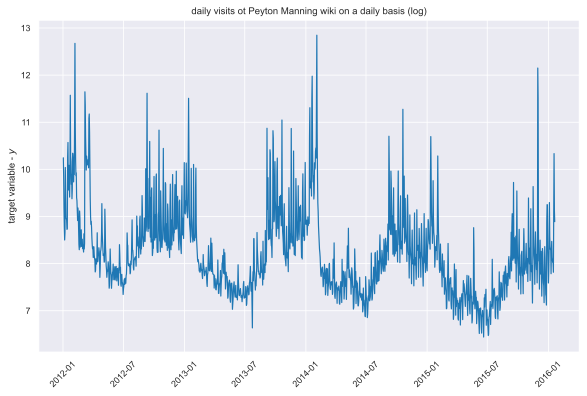

In [5]:
plt.plot_date(
    x=df_in["ds"],
    y=df_in["y"],
    label="input timeseries",
    fmt="-",
)
plt.tick_params(axis="x", rotation=45)
plt.ylabel("target variable - $y$")
plt.title("daily visits ot Peyton Manning wiki on a daily basis (log)")
plt.show()

I have selected data from 2012 onwards, this should be enough to test drive the seasonal dummies. The first thing that I notice is that there is a dip around months 06 and 07. In early August teams play so [exhibition games](https://en.wikipedia.org/wiki/NFL_preseason) before the start of the actual season. 

Also, we can observe a pattern over the year, it starts high then dips, and then and high again. This can be seen for the other years as well, so there is some repeating seasonality. Let us continue and train our first models. Starting with a simple ordinary linear regression and then adding dummies to see if they improve the performance of the model.


## Train-test split

In [6]:
# train test split
df_train = df_in[(df_in["ds"] > "2012") & (df_in["ds"] < "2015")]
df_test = df_in[(df_in["ds"] > "2015")]

To gauge the performance of the model the data is split in two parts, the train data from 2012 up to 2015 and the test data everything after 2015. The model will only see the train data and is asked to create a prediction for the test data, after which we will calculate the perfomance with the predictions and the true observations.

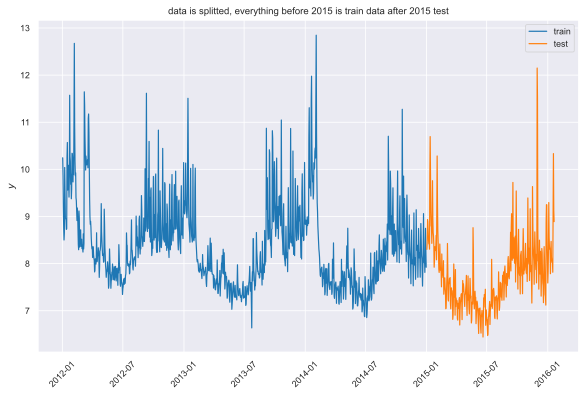

In [7]:
# visually inspect the train test split
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)
plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title("data is splitted, everything before 2015 is train data after 2015 test")
plt.show()

## Setting up the regression

In [8]:
X_train = df_train["ds"].astype(int).to_numpy().reshape(-1, 1)
y_train = df_train["y"].to_numpy()

X_test = df_test["ds"].astype(int).to_numpy().reshape(-1, 1)
y_test = df_test["y"].to_numpy()

Shaping and converting the data so that we can fit the linear model. 
In this case, we are converting the date columns into an ever-increasing integer.


In [9]:
# creating, fit, and inference
linear = LinearRegression()
linear.fit(X=X_train, y=y_train)
y_pred = linear.predict(X=X_test)

Fitting the linear model is very fast, around 4 milliseconds on my machine, and yes, I know the data volume is low(actually for time series it is pretty decent), but this allows me to fit 1000 models in 4 seconds. So, we can make predictions on 1000 different time series, all in the time it takes to take a sip of coffee☕️.

Anyways lets us visually inspect the results of the model, by plotting all the components (train, test, predictions) that we have gathered. Also, let us calculate two error metrics [mse](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) and [mae](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) that way we can quantify the performance of the model.


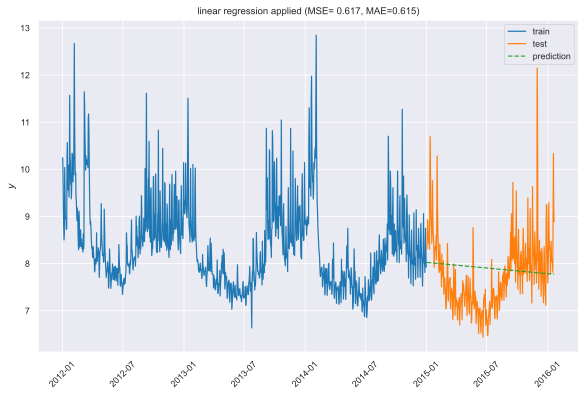

In [10]:
# calc error metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# visually inspect the prediction
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred,
    label="prediction",
    fmt="--",
)

plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(f"linear regression applied (MSE= {mse:.3}, MAE={mae:.3})")
plt.show()

The model is just a boring straight line, but what did you expect with a linear model ?! The green line is passing through the orange blob more or less, and intuitively it kind of moves in the right direction. However, it doesn't capture the seasonality or other patterns of the train set. The two error metrics mse and mae are both around 0.6. this in itself does not say much, but we can use this as the 'benchmark' and try to improve on this with the addition of the dummies.

In [11]:
# | echo: false
print(f"mean squared error  = {mse:.3}")
print(f"mean absolute error = {mae:.3}")

mean squared error  = 0.617
mean absolute error = 0.615


## Adding dummies

Let us add some dummies for the months and see if we can improve the performance of the model visually and on the metrics. For each month we create a column that can either have the value of `0` or `1`. if the value is `1` then that row corresponds to that particular month, in this way we are actively encoding this knowledge into the model. in this way the model can learn the magnitude and direction of each month and apply that to future predictions. at least that is the idea, let us test that!

In [12]:
# creating dummies for the months
df_dummies = df_in.assign(
    month=df_in["ds"].dt.month.astype("category"),
    ds_int=df_in["ds"].astype(int),
)

not_dummy = {"y", "ds", "ds_int"}
to_dummy = list(set(df_dummies.columns) - not_dummy)

df_dummies = pd.get_dummies(data=df_dummies, columns=to_dummy)
all_features = list(set(df_dummies.columns) - {"y", "ds"})

# slicing the input in train test
df_train_dummies = df_dummies[(df_dummies["ds"] > "2012") & (df_dummies["ds"] < "2015")]
df_test_dummies = df_dummies[(df_dummies["ds"] > "2015")]

X_train = df_train_dummies.loc[:, all_features]
y_train = df_train_dummies[["y"]]

X_test = df_test_dummies.loc[:, all_features]
y_test = df_test_dummies[["y"]]

df_dummies.drop(columns=["ds_int", "y"]).sample(
    n=6,
    ignore_index=True,
    random_state=42,
)

,ds,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2014-05-06,False,False,False,False,True,False,False,False,False,False,False,False
1,2012-07-05,False,False,False,False,False,False,True,False,False,False,False,False
2,2015-06-21,False,False,False,False,False,True,False,False,False,False,False,False
3,2012-03-09,False,False,True,False,False,False,False,False,False,False,False,False
4,2012-08-10,False,False,False,False,False,False,False,True,False,False,False,False
5,2013-05-11,False,False,False,False,True,False,False,False,False,False,False,False


In the code block above we are adding the dummies for the month to the data. In this case `month_1` is jan and `month_12` is dec.

Next up we are training the model with the added dummies and plotting the results next to the model without the dummies.


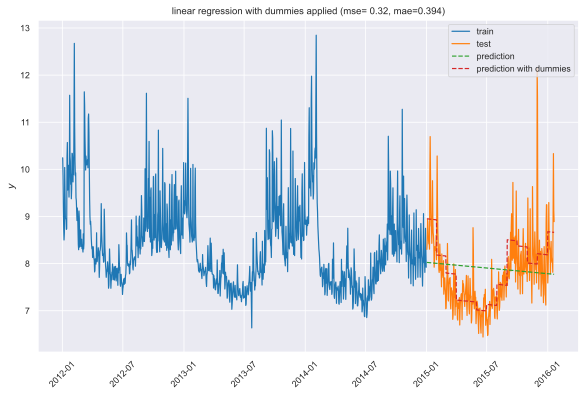

In [13]:
# create the pipeline and fit pipeline
# scaler is there so that the coefs can be interpeted later
# pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline = make_pipeline(MinMaxScaler(), LinearRegression())

pipeline.fit(X=X_train, y=y_train)
y_pred_dummies = pipeline.predict(X=X_test)

mse_dummies = mean_squared_error(y_test, y_pred_dummies)
mae_dummies = mean_absolute_error(y_test, y_pred_dummies)

plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred,
    label="prediction",
    fmt="--",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred_dummies,
    label="prediction with dummies",
    fmt="--",
)

plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(
    f"linear regression with dummies applied (mse= {mse_dummies:.3}, mae={mae_dummies:.3})"
)
plt.show()

Visually the forecast already looks a lot better. It follows the peaks and valleys of the time-series, and it captures the overall trend better. this is also reflected when we look at the error metrics and the improvement factor that we have achieved. the mean squared error improved with a factor of 1.89 and the mean absolute error improved with a factor of 1.54. That is impressive for just adding a bunch of ones and zeros.

In [14]:
print(f"mean squared error  = {mse_dummies:.3}")
print(f"improvement factor mse month dummies -> {mse/mse_dummies:.3}x")

print("-" * 79)

print(f"mean absolute error = {mae_dummies:.3}")
print(f"improvement factor mea month dummies -> {mae/mae_dummies:.3}x")

mean squared error  = 0.32
improvement factor mse month dummies -> 1.93x
-------------------------------------------------------------------------------
mean absolute error = 0.394
improvement factor mea month dummies -> 1.56x


## Inspecting the seasonality

Now that we have encoded the information about the seasonality in the model, this also allows us to inspect that seasonality by itself. this would give us some insight into the inner workings of the underlying time series model. first we access the coefficients of the linear model and put them into a separate dataframe. then we need to scale them so that the relative difference is more apparent. looking at the raw coefficients would not yield any information as the scale is not relatable to the original problem.

In [15]:
# |code-fold: show
# pull coefs into a seperate df, to inspect the seasonality
lin_reg_coefs = (
    pd.DataFrame(
        data=pipeline["linearregression"].coef_,
        columns=X_train.columns,
    )
    .T.reset_index()
    .rename(columns={"index": "month", 0: "coefficient"})
)
# exclude the time col
lin_reg_coefs = lin_reg_coefs[lin_reg_coefs["month"] != "ds_int"]

# subtract mean to get the relative difference between the coefs
lin_reg_coefs["coefficient"] = (
    lin_reg_coefs["coefficient"] - lin_reg_coefs["coefficient"].mean()
)

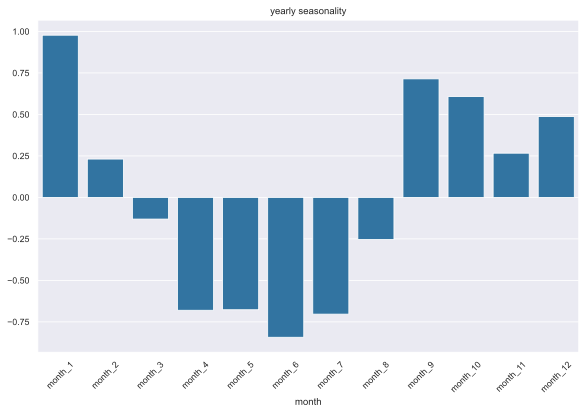

In [16]:
chart = sns.barplot(
    data=lin_reg_coefs,
    x="month",
    y="coefficient",
    color=sns.color_palette()[0],
    order=[f"month_{i}" for i in range(1, 13)],
)
plt.tick_params(axis="x", rotation=45)
plt.ylabel("")
plt.title("yearly seasonality")
plt.show()

Now we have a beautiful overview of the seasonality over the year. we can clearly see a dip in the middle of the year and a significant uptick in the month of January. in the first week of February, the super bowl is played which is a major factor in the traffic to the wiki page. Also, we noticed that there was a dip in the middle of the year which we can also clearly see at the `month_6` mark.

## Recap

In this blog post I have demonstrated that the performance of a simple linear regression for time series forecasting can be improved by a factor of 1.54 up to 1.89 by simply adding dummy variables for the months. the nice thing about this is that the linear regression is available in most systems that have some kind of analytical capability (yes even in [excel](https://exceljet.net/functions/linest-function)) and adding the dummies is so simple that you can even do it in a SQL server, the added benefit of this all is that the fitting of the model is quick, therefore you can retrain the model monthly 😉, weekly, daily, hourly.

## Encore 

What if we were to dummies not just for the months, but also for other datetime features and really turn it up to [eleven](https://www.youtube.com/watch?v=4xgx4k83zzc)


![ ](artifacts/all_the_things.jpg)

Let us create dummies for the following datetime features:

- month
- week
- dayofweek
- is_weekend
- quarter

when converting this to dummies it will result in a tremendous number of extra features and therefore we will apply a [Elasticnet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) linear model. Usually, this type of model can handle lots of features better than an ordinary linear regression because of the regularization, this will be left as an exercise for the reader.


In [17]:
# creating dummies for the months
df_dummies_all = df_in.assign(
    month=df_in["ds"].dt.month.astype("category"),
    week=df_in["ds"].dt.isocalendar().week.astype("category"),
    dayofweek=df_in["ds"].dt.dayofweek.astype("category"),
    is_weekend=(df_in["ds"].dt.dayofweek) >= 5,
    quarter=df_in["ds"].dt.quarter.astype("category"),
    ds_int=df_in["ds"].astype(int),
)

not_dummy = {"y", "ds", "ds_int"}
to_dummy = list(set(df_dummies_all.columns) - not_dummy)

df_dummies_all = pd.get_dummies(
    data=df_dummies_all,
    columns=to_dummy,
    drop_first=True,  # reduce the amount of cols with no additional info
)
all_features = list(set(df_dummies_all.columns) - {"y", "ds"})

# slicing the input in train test
df_train_dummies_all = df_dummies_all[
    (df_dummies_all["ds"] > "2012") & (df_dummies_all["ds"] < "2015")
]
df_test_dummies_all = df_dummies_all[(df_dummies_all["ds"] > "2015")]

X_train = df_train_dummies_all.loc[:, all_features]
y_train = df_train_dummies_all[["y"]]

X_test = df_test_dummies_all.loc[:, all_features]
y_test = df_test_dummies_all[["y"]]

df_dummies_all.drop(columns=["ds_int", "y"]).sample(
    n=6,
    ignore_index=True,
    random_state=42,
)

,ds,is_weekend_True,quarter_2,quarter_3,quarter_4,month_2,month_3,month_4,month_5,month_6,...,week_50,week_51,week_52,week_53,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2014-05-06,False,True,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1,2012-07-05,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2015-06-21,True,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,2012-03-09,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2012-08-10,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,2013-05-11,True,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


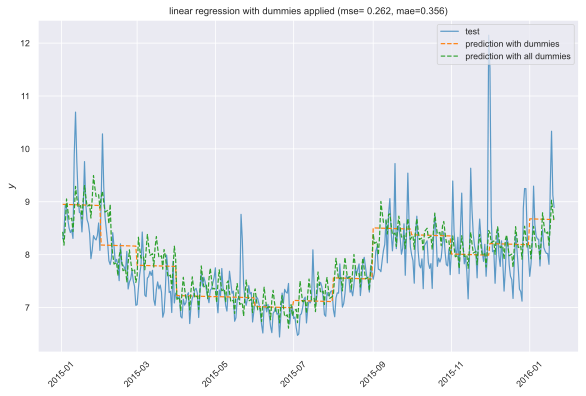

In [18]:
# utilzing an elasticnet linear model to compensate for the amount of features
elastic_params = {
    "l1_ratio": np.linspace(start=0.000001, stop=1, num=100),
    "cv": 7,
    "n_alphas": 1_00,
    "n_jobs": -1,
}

pipeline_all = make_pipeline(MinMaxScaler(), ElasticNetCV(**elastic_params))

pipeline_all.fit(X=X_train, y=y_train.to_numpy().ravel())
y_pred_dummies_all = pipeline_all.predict(X=X_test)

mse_dummies_all = mean_squared_error(y_test, y_pred_dummies_all)
mae_dummies_all = mean_absolute_error(y_test, y_pred_dummies_all)

plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
    alpha=0.7,
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred_dummies,
    label="prediction with dummies",
    fmt="--",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred_dummies_all,
    label="prediction with all dummies",
    fmt="--",
)


plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(
    f"linear regression with dummies applied (mse= {mse_dummies_all:.3}, mae={mae_dummies_all:.3})"
)
plt.show()

Immediately it becomes obvious that the model captures more of the fine-grained movement of the time series. this is also reflected in the fact that both error metrics have improved.

In [19]:
print(f"mean squared error = {mse_dummies_all:.3}")
print(f"improvement factor mse month dummies -> {mse/mse_dummies:.3}x")
print(f"improvement factor mse all dummies   -> {mse/mse_dummies_all:.3}x")
print("-" * 79)

print(f"mean absolute error = {mae_dummies_all:.3}")
print(f"improvement factor mea month dummies -> {mae/mae_dummies:.3}x")
print(f"improvement factor mea all dummies   -> {mae/mae_dummies_all:.3}x")

mean squared error = 0.262
improvement factor mse month dummies -> 1.93x
improvement factor mse all dummies   -> 2.35x
-------------------------------------------------------------------------------
mean absolute error = 0.356
improvement factor mea month dummies -> 1.56x
improvement factor mea all dummies   -> 1.73x


In [20]:
# | echo: false
# | output: false
import gif  # noqa

In [21]:
# | echo: false
# | output: false

# setting mpl params
fig_height = 2.0
fig_width = fig_height * 1.618
# plt.rcParams["figure.figsize"] = [fig_width, fig_height]
# plt.rcParams["figure.dpi"] = 100

with plt.rc_context({"figure.figsize": [fig_width, fig_height], "figure.dpi": 100}):
    # create on frame of the blend between linear and dummie regression lines
    @gif.frame
    def create_blend_gif(ratio):
        y_blend = (ratio * y_pred).reshape(-1, 1) + (1 - ratio) * y_pred_dummies
        with sns.axes_style("whitegrid"):
            plt.ylim(y_pred_dummies.min(), y_pred_dummies.max())
            plt.plot_date(
                x=df_test["ds"],
                y=y_blend,
                fmt="-",
            )
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # loop over all frames
    num_of_frames = 66
    gif_frames = [
        create_blend_gif(i) for i in np.linspace(start=0, stop=1, num=num_of_frames)
    ]

    # freeze on the bounce point
    gif_frames.extend([gif_frames[-1] for _ in range(num_of_frames // 6)])

    # add the the original series in reverse
    gif_frames.extend(gif_frames[::-1])

    # export the gif
    gif.save(
        gif_frames,
        "artifacts/ratio.gif",
        # duration=0.1, # seconds
    )